<h1><u>Introduction:</u></h1>
<span style="color:blue"><b>The following notebook implements both a package and scratch-made Lasso model used to predict base frequency based on a CPU's architectual components. The code also includes some pre-processing and data analysis.</b></span>

In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

processors = pd.read_csv('processors.csv')

In [2]:
processors

,cores,lithography,base_frequency,tdp,max_temp,sku,cache_size,processor_performance,socket_group,memory_group,brand
0,16.0,7.0,3400.0,105.0,90.0,10456,65536.0,High Tier,LGA,DDR4,0
1,12.0,7.0,3700.0,105.0,90.0,10461,65536.0,High Tier,LGA,DDR4,0
2,12.0,7.0,3000.0,65.0,95.0,10796,65536.0,High Tier,LGA,DDR4,0
3,8.0,7.0,3800.0,105.0,90.0,10466,32768.0,Mid Tier,LGA,DDR4,0
4,8.0,7.0,3400.0,65.0,95.0,10791,32768.0,Mid Tier,LGA,DDR4,0
...,...,...,...,...,...,...,...,...,...,...,...
1523,8.0,14.0,2300.0,80.0,100.0,136434,11264.0,High Tier,BGA,DDR4,1
1524,12.0,14.0,2200.0,90.0,100.0,136435,16896.0,High Tier,BGA,DDR4,1
1525,14.0,14.0,1900.0,105.0,100.0,136436,19456.0,High Tier,BGA,DDR4,1
1526,12.0,14.0,2100.0,75.0,100.0,136437,17408.0,High Tier,BGA,DDR4,1


<span style="color:blue"><b>Above, you can see the combined dataset of our CPU units and their various component features. Now, we will look at the skew of our combined dataset to determine the transformation of our numerical columns for our Lasso model.</b></span>

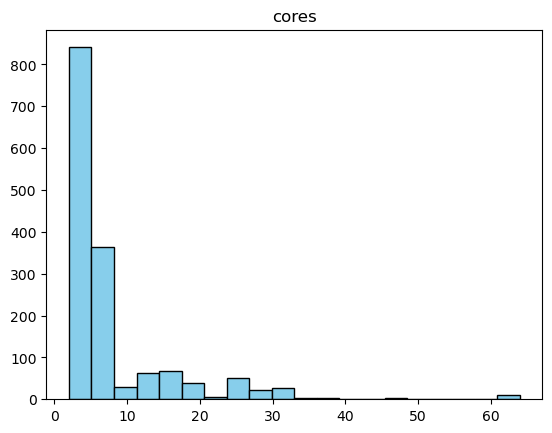

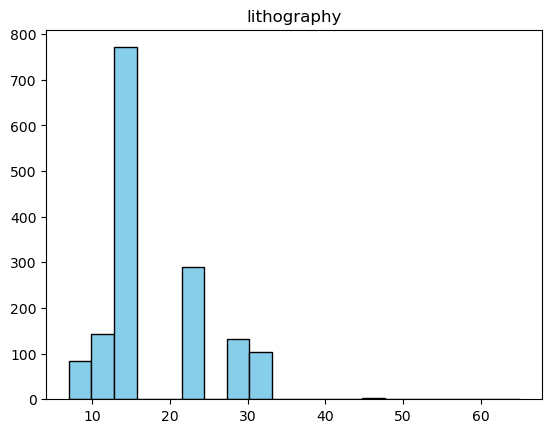

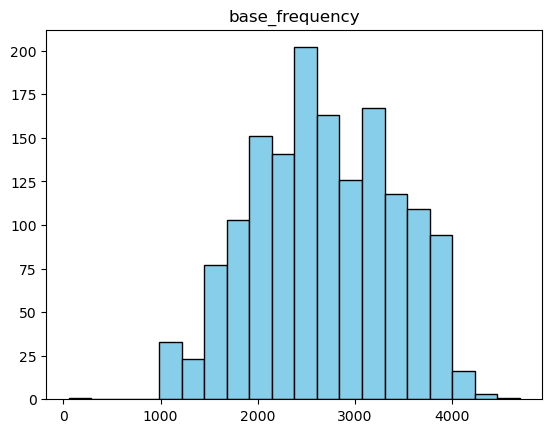

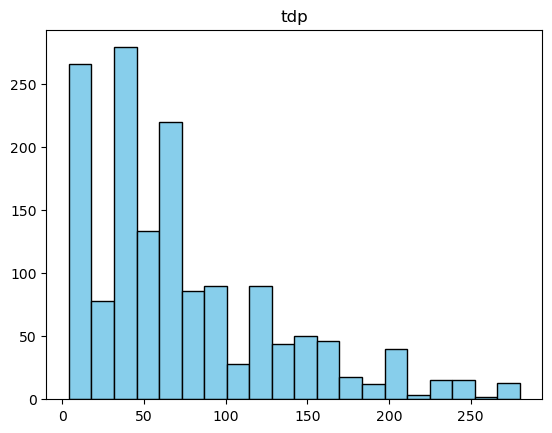

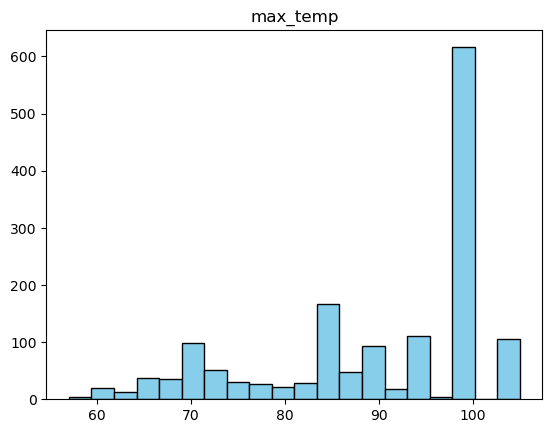

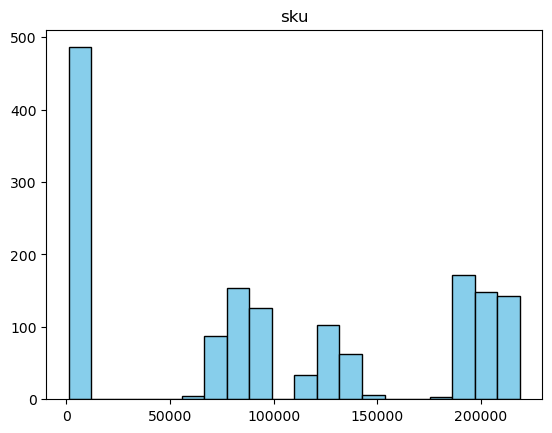

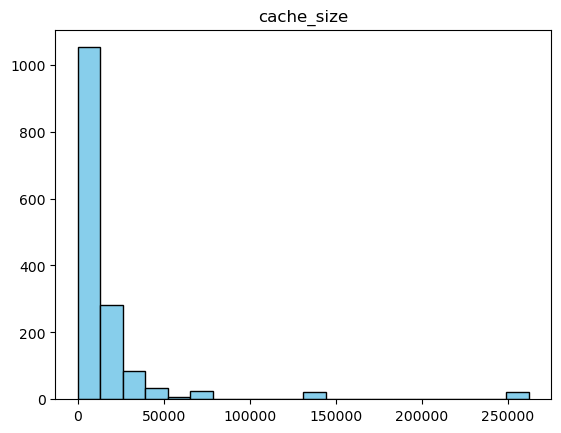

cores skewness: 3.0936522129116786
lithography skewness: 1.0175484771840544
base_frequency skewness: -0.0641354117672257
tdp skewness: 1.2132681349384347
max_temp skewness: -0.7913051273254886
sku skewness: 0.08611120353828798
cache_size skewness: 5.423716060086098


In [3]:
for i in processors.columns[:7]:
    plt.hist(processors[i], bins=20, color='skyblue', edgecolor='black')
    plt.title(i)
    plt.show()

for i in processors.columns[:7]:
    skew = processors[i].skew()
    print(f'{i} skewness: {skew}')

<span style="color:blue"><b>Before we transform the data, we will create a copy of the original and transform on the copy. If a column contains a large skew, it will be log transformed whereas a small skew will utilize a square root transformation.</b></span>

In [4]:
norm_processors = processors.copy()
norm_processors['cores'] = np.log1p(norm_processors['cores'])
norm_processors['lithography'] = np.sqrt(norm_processors['lithography'])
norm_processors['tdp'] = np.log1p(norm_processors['tdp'])
norm_processors['cache_size'] = np.log1p(norm_processors['cache_size'])

<span style="color:blue"><b>Because our dataset contains categorical columns with multiple groupings each, we will need to create dummy columns. Additioanlly, because we are using varying units in our data, it will need to be standard scaled to avoid over-influence of some features.</b></span>

In [5]:
X = pd.get_dummies(norm_processors[['cores', 'lithography', 'tdp', 'max_temp', 'sku', 'cache_size', 'processor_performance', 'socket_group', 'memory_group', 'brand']], drop_first=True)
y = norm_processors['base_frequency']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<h2><u>Package Model:</u></h2>
<span style="color:blue"><b>We will first k-fold cross validate our package model to determine the most optimal alpha penalty value. Following that we will train the package model with the optimal alpha value and test on our target-test split. We will also look at our coefficient values to interpret what the model deemed influential or not.</b></span>

In [6]:
alpha_values_pack = [0.001, 0.01, 0.1, 1, 10, 50, 100]

kf_pack = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for alpha in alpha_values_pack:
    lasso = Lasso(alpha=alpha, max_iter=5000)
    errors = []
    
    for train, test in kf_pack.split(X_scaled):
        X_train, X_test = X_scaled[train], X_scaled[test]
        y_train, y_test = y[train], y[test]
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        errors.append(mse)
    
    avg_mse = np.mean(errors)
    results.append(avg_mse)

alpha_index_1 = results.index(min(results))

In [7]:
optimal_alpha_1 = alpha_values_pack[alpha_index_1]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

package_lasso = Lasso(alpha=optimal_alpha_1, max_iter=5000)
package_lasso.fit(X_train_1, y_train_1)

pack_y_pred = package_lasso.predict(X_test_1)
pack_mse = mean_squared_error(y_test_1, pack_y_pred)
pack_r2 = r2_score(y_test_1, pack_y_pred)

In [8]:
print(f'Optimal Alpha {optimal_alpha_1}')
print(f'Test MSE: {pack_mse}')
print(f'Test RMSE: {np.sqrt(pack_mse)}')
print(f'Test R^2 Score {pack_r2}')
print()
for i in range(len(X.columns)):
    print(f'Learned Coefficient for {X.columns[i]}: {package_lasso.coef_[i]}')

Optimal Alpha 1
Test MSE: 158545.32048064776
Test RMSE: 398.17749871212936
Test R^2 Score 0.71207983188017

Learned Coefficient for cores: -649.7927340211648
Learned Coefficient for lithography: -190.0994791505721
Learned Coefficient for tdp: 655.9192002287593
Learned Coefficient for max_temp: -0.0
Learned Coefficient for sku: -7.490713431144998
Learned Coefficient for cache_size: 157.00913005559775
Learned Coefficient for brand: -188.70805280946084
Learned Coefficient for processor_performance_Low Tier: 98.0750663620392
Learned Coefficient for processor_performance_Mid Tier: 47.84956119265635
Learned Coefficient for processor_performance_Other: -32.43028351448757
Learned Coefficient for socket_group_FCPGA: 98.39050518743491
Learned Coefficient for socket_group_LGA: 143.02418436008563
Learned Coefficient for socket_group_Other: -16.491609947277936
Learned Coefficient for socket_group_Threadripper: 15.794783823343055
Learned Coefficient for memory_group_DDR3: 0.0
Learned Coefficient for

<span style="color:blue"><b>Above we can see the results of the package model. Based off our RMSE we can see that this model is off about 398 MHz on average, while our R^2 value says that about 71% of the data's underlying complexity is explained. We can also see the varying coefficients and how they represent our feature relationships with base frequency. What is noticeable is that the Lasso penalty only zeroed the features of 'max_temp' and 'memory_group_DDR3'.</b></span>

<h2><u>Scratch Model:</u></h2>
<span style="color:blue"><b>Now will replicate a Lasso regression model by scratch. Below is our Lasso model through the use of a class. This is helpful to organize the different functions of a Lasso model respective to each instance of the class.</b></span>

In [9]:
class MyLasso:
    '''

    MyLasso implements a scratch model of Lasso regression that allows the user to manually set
    parameters as well as view the mathematical inner-workings of Lasso regression. 

    '''
    def __init__(self, alpha=1.0, max_iter=5000, tol=1e-4):
        '''

        alpha: penalty (int)
        max_iter: maximum iterations allowed (int)
        tol: compares change in coefficients (float)

        The Lasso class parameters are initialized.

        '''
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.coeffs = None
        
    def soft_threshold(self, value, alpha):
        '''

        value: previous coefficient (float)
        alpha: Lasso penalty (float)
        return: new coefficient (float)

        Updates a given coefficient by applying the proper alpha penalty.

        '''
        if value > alpha:
            return value - alpha
        elif value < -alpha:
            return value + alpha
        else:
            # value is between -alpha and alpha
            return 0

    def fit(self, X, y):
        '''

        X: feature vector (np.ndarray)
        y: target vector (np.ndarray)

        The Lasso regression model is fitted to the desired data by initializing coefficients for 
        each feature and applying a penalty to them in each iteration. When max iteration is 
        reached, the coefficients should be optimized to match proper feature influence on
        prediction.
        
        '''
        rows, columns = X.shape
        w = np.zeros(columns) # all coefficients start as zero
        
        for i in range(self.max_iter): # iterations of Lasso 
            old_w = w.copy() # previous weights are stored
            
            for j in range(columns):
                # find the influence this feature has on the total error
                influence = y - (X @ w) + w[j] * X[:, j]

                # correlation between feature and residual
                corr = np.dot(X[:, j], influence)

                # update coefficient using soft thresholding
                w[j] = self.soft_threshold(corr / np.sum(X[:, j] ** 2), self.alpha) # corr / np.sum(X[:, j] ** 2) is update without penalty

            # stops early if weight change is < tolerance level
            if np.sum(np.abs(w - old_w)) < self.tol:
                break
                
        self.coeffs = w
                
    def predict(self, X):
        '''

        X: feature vector (np.ndarray)
        return: predictions for the data (np.ndarray)

        Generates predictions for the given data. 

        '''
        return X @ self.coeffs

<span style="color:blue"><b>Now we will do the same process as we did with our package model. We will cross-validate for an optimal alpha value. That optimal alpha will then be used in our training and testing of our scratch-made Lasso model.</b></span>

In [10]:
alpha_values_scratch = [0.001, 0.01, 0.1, 1, 10, 50, 100]

kf_scratch = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for alpha in alpha_values_scratch:
    lasso = MyLasso(alpha=alpha, max_iter=5000)
    errors = []
    
    for train, test in kf_scratch.split(X_scaled):
        X_train, X_test = X_scaled[train], X_scaled[test]
        y_train, y_test = y[train], y[test]
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        errors.append(mse)
    
    avg_mse = np.mean(errors)
    results.append(avg_mse)

alpha_index_2 = results.index(min(results))

In [11]:
optimal_alpha_2 = alpha_values_scratch[alpha_index_2]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

final_lasso = MyLasso(alpha=optimal_alpha_2, max_iter=5000)
y_centered = y_train_2 - y_train_2.mean() # center training targets due to scratch
final_lasso.fit(X_train_2, y_centered)

scratch_y_pred = final_lasso.predict(X_test_2) + y_train_2.mean() # add mean back
scratch_mse = mean_squared_error(y_test_2, scratch_y_pred)
scratch_r2 = r2_score(y_test_2, scratch_y_pred)

In [12]:
print(f'Optimal Alpha {optimal_alpha_2}')
print(f'Test MSE: {scratch_mse}')
print(f'Test RMSE: {np.sqrt(scratch_mse)}')
print(f'Test R^2 Score {scratch_r2}')
print()
for i in range(len(X.columns)):
    print(f'Learned Coefficient for {X.columns[i]}: {final_lasso.coeffs[i]}')

Optimal Alpha 50
Test MSE: 211920.21624457155
Test RMSE: 460.34792955390986
Test R^2 Score 0.6151503929340161

Learned Coefficient for cores: -371.4882772448049
Learned Coefficient for lithography: -45.63018464096315
Learned Coefficient for tdp: 521.1458511987437
Learned Coefficient for max_temp: 0.0
Learned Coefficient for sku: 0.0
Learned Coefficient for cache_size: 0.0
Learned Coefficient for brand: -109.94381546275082
Learned Coefficient for processor_performance_Low Tier: 0.0
Learned Coefficient for processor_performance_Mid Tier: 0.0
Learned Coefficient for processor_performance_Other: 0.0
Learned Coefficient for socket_group_FCPGA: 38.597250363671776
Learned Coefficient for socket_group_LGA: 129.28214197623666
Learned Coefficient for socket_group_Other: 0.0
Learned Coefficient for socket_group_Threadripper: 0.0
Learned Coefficient for memory_group_DDR3: 0.0
Learned Coefficient for memory_group_DDR4: 0.0
Learned Coefficient for memory_group_LPDDR4: 0.0
Learned Coefficient for mem

<span style="color:blue"><b></b></span>

<span style="color:blue"><b>Looking at our results, we can see that the scratch model is off about 460 MHz based on our RMSE value. Additionally, we can see from our R^2 value that the scratch model explains about 62% of the data's variance. When looking at the coefficient weights that our model calculated to, we can see a number of features were zeroed out in the regularization process. This is an obvious difference when comparing our models and illustrates the difficulty in creating a completely from-scratch Lasso model.</span></b>

In [13]:
compare_table = pd.DataFrame(index=X.columns, columns=['Package', 'Scratch'])

for i in range(len(final_lasso.coeffs)):
    compare_table.iloc[i, 1] = final_lasso.coeffs[i]

for i in range(len(package_lasso.coef_)):
    compare_table.iloc[i, 0] = package_lasso.coef_[i]

compare_table

,Package,Scratch
cores,-649.792734,-371.488277
lithography,-190.099479,-45.630185
tdp,655.9192,521.145851
max_temp,-0.0,0.0
sku,-7.490713,0.0
cache_size,157.00913,0.0
brand,-188.708053,-109.943815
processor_performance_Low Tier,98.075066,0.0
processor_performance_Mid Tier,47.849561,0.0
processor_performance_Other,-32.430284,0.0


<span style="color:blue"><b>Above is a table of both models' calculated coefficients to make analysis easier.</b></span>